In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Normal STTS setup

In [1]:
!git clone https://github.com/SanjanaHukkeriIIITH/StyleVC.git
%cd StyleVC


Cloning into 'StyleVC'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 164 (delta 18), reused 31 (delta 10), pack-reused 119 (from 3)
Receiving objects: 100% (164/164), 102.94 MiB | 46.52 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/kaggle/working/StyleVC


In [2]:
!pip install munch sentence-transformers librosa==0.10.1 torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninsta

In [3]:
# load packages
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa

from models import *
from utils import *

%matplotlib inline

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

def length_to_mask(lengths):
    mask = torch.arange(lengths.max()).unsqueeze(0).expand(lengths.shape[0], -1).type_as(lengths)
    mask = torch.gt(mask+1, lengths.unsqueeze(1))
    return mask

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def compute_style(ref_dicts):
    reference_embeddings = {}
    for key, path in ref_dicts.items():
        wave, sr = librosa.load(path, sr=24000)
        audio, index = librosa.effects.trim(wave, top_db=25)
        if sr != 24000:
            audio = librosa.resample(audio, sr, 24000)
        mel_tensor = preprocess(audio).to(device)

        with torch.no_grad():
            ref = model.style_encoder(mel_tensor.unsqueeze(1))
        reference_embeddings[key] = (ref.squeeze(1), audio)
    
    return reference_embeddings

In [6]:
import sys
sys.path.insert(0, "./Demo/hifi-gan")

import glob, os, json
import torch
from munch import Munch
from vocoder import Generator
from scipy.io.wavfile import write

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint(filepath, device):
    print("Loading checkpoint:", filepath)
    return torch.load(filepath, map_location=device)

def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    files = glob.glob(pattern)
    return sorted(files)[-1] if files else ''


In [7]:
cp_g = "/kaggle/input/styleevc-checkpoints/g_00935000"
config_file = "/kaggle/working/StyleVC/Vocoder/LibriTTS/config.json"

with open(config_file) as f:
    json_config = json.load(f)

h = Munch(json_config)
generator = Generator(h).to(device)

state_dict_g = load_checkpoint(cp_g, device)
generator.load_state_dict(state_dict_g["generator"])
generator.eval()
generator.remove_weight_norm()
print("HiFi-GAN loaded.")


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Loading checkpoint: /kaggle/input/styleevc-checkpoints/g_00935000
Removing weight norm...
HiFi-GAN loaded.


In [8]:
import yaml
from munch import Munch
import librosa

model_path = "/kaggle/input/styleevc-checkpoints/epoch_2nd_00100.pth"
model_config_path = "/kaggle/working/StyleVC/Models/VCTK/config_styletts.yml"

config = yaml.safe_load(open(model_config_path))


In [9]:
ASR_config = config['ASR_config']
ASR_path   = config['ASR_path']
text_aligner = load_ASR_models(ASR_path, ASR_config)

F0_path = config['F0_path']
pitch_extractor = load_F0_models(F0_path)


In [10]:
model = build_model(Munch(config['model_params']), text_aligner, pitch_extractor)

# params = torch.load(model_path, map_location='cpu')['net']
params = torch.load(model_path, map_location='cpu', weights_only=False)['net']


for key in model:
    if key in params and "discriminator" not in key:
        print(f"{key} loaded")
        model[key].load_state_dict(params[key])

for key in model:
    model[key] = model[key].to(device).eval()

print("StyleTTS-VC model loaded.")


mel_encoder loaded
linear_proj loaded
decoder loaded
pitch_extractor loaded
text_encoder loaded
style_encoder loaded
text_aligner loaded
StyleTTS-VC model loaded.


In [11]:
ref_wav = "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Angry/0001_000351.wav"   # your own path
ref_dicts = {"sample_ref": ref_wav}
reference_embeddings = compute_style(ref_dicts)
first_key = list(reference_embeddings.keys())[0]
style_tensor, ref_audio = reference_embeddings[first_key]

print("Style tensor shape:", style_tensor.shape)


Style tensor shape: torch.Size([1, 128])


In [12]:
# ===========================
# LOAD INPUT AUDIO
# ===========================
import IPython.display as ipd

input_audio = "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000003.wav"

wave, sr = librosa.load(input_audio, sr=24000)
wave = wave / np.max(np.abs(wave))
print("Loaded input:")
display(ipd.Audio(wave, rate=24000))

mel = preprocess(wave).to(device)


Loaded input:


In [13]:
with torch.no_grad():
    asr = model.mel_encoder(mel)
    F0_real, _, _ = model.pitch_extractor(mel.unsqueeze(1))
    real_norm = log_norm(mel.unsqueeze(1)).squeeze(1)


## Prompt + Style injection (sentence transformer)

In [ ]:
# ===========================
# PROMPT → STYLE PROJECTION
# ===========================

from sentence_transformers import SentenceTransformer
import torch.nn as nn

# Load text embedding model
txt_encoder = SentenceTransformer("all-mpnet-base-v2").to(device)

# Your style embedding dim = 128
STYLE_DIM = 128

# Two-layer MLP to map 768 → 256 → 128
prompt_proj = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, STYLE_DIM)
).to(device)

# Convert prompt to style embedding
def prompt_to_style(prompt: str):
    with torch.no_grad():
        emb = txt_encoder.encode(prompt)
        emb = torch.tensor(emb).float().to(device)          # (768,)
        style = prompt_proj(emb).unsqueeze(0)               # (1,128)
        return style


In [15]:
real_styles = []

ref_paths = [
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Angry/0001_000351.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Angry/0001_000352.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Happy/0001_000702.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Happy/0001_000707.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Sad/0001_001051.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Sad/0001_001061.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Neutral/0001_000002.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Neutral/0001_000012.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Surprise/0001_001402.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0001/Surprise/0001_001413.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0002/Happy/0002_000701.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0002/Happy/0002_000707.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0002/Neutral/0002_000002.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0002/Neutral/0002_000008.wav",
    "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0002/Sad/0002_001053.wav"
    
    
    
]

for p in ref_paths:
    w, _ = librosa.load(p, sr=24000)
    w = w / np.max(np.abs(w))
    mel = preprocess(w).to(device)
    with torch.no_grad():
        s = model.style_encoder(mel.unsqueeze(1)).squeeze().cpu().numpy()
    real_styles.append(s)

real_styles = np.stack(real_styles)


In [16]:
style_mean = torch.tensor(real_styles.mean(axis=0)).float().to(device)
style_std  = torch.tensor(real_styles.std(axis=0)).float().to(device)

print("Calibrated style distribution built.")


Calibrated style distribution built.


In [17]:
def prompt_to_style(prompt):
    with torch.no_grad():
        emb = txt_encoder.encode(prompt)
        emb = torch.tensor(emb).float().to(device)

        raw = prompt_proj(emb)               # (128)
        calibrated = raw * style_std + style_mean

        return calibrated.unsqueeze(0)


In [18]:
def infer_from_prompt(prompt):
    style = prompt_to_style(prompt).to(device)

    with torch.no_grad():
        out = model.decoder(asr, F0_real.unsqueeze(0), real_norm, style)
        mel_out = out.squeeze()

    with torch.no_grad():
        wav_out = generator(mel_out.unsqueeze(0)).squeeze().cpu().numpy()

    return wav_out


In [19]:
prompts = [
    "speak with soft sadness and low energy",
    "speak angrily with tension and harsh energy",
    "speak with excitement and high energy",
    "speak calmly with a soothing relaxed tone",
    "sound surprised and expressive",
]

results = {}

for p in prompts:
    print("Prompt:", p)
    wav_out = infer_from_prompt(p)
    results[p] = wav_out
    display(ipd.Audio(wav_out, rate=24000))
    print("-" * 80)


Prompt: speak with soft sadness and low energy


NameError: name 'txt_encoder' is not defined

In [33]:
# ===========================
# PROMPT CONDITIONED INFERENCE
# ===========================

prompt = "speak calmly with a smooth relaxed tone"
print("Prompt:", prompt)

style_vec = prompt_to_style(prompt).to(device)

with torch.no_grad():
    out = model.decoder(asr, F0_real.unsqueeze(0), real_norm, style_vec)
    mel_out = out.squeeze()

# vocoder synthesis
with torch.no_grad():
    wav_out = generator(mel_out.unsqueeze(0)).squeeze().cpu().numpy()

display(ipd.Audio(wav_out, rate=24000))


Prompt: speak calmly with a smooth relaxed tone


In [27]:
# ============================================
# MULTIPLE-PROMPT EMOTIONAL VC TESTING
# ============================================

prompts = [
    "speak with soft sadness and low energy",
    "speak angrily with tension and force",
    "speak with excitement and high energy",
    "speak calmly with a smooth relaxed tone",
    "sound surprised and expressive",
    "speak in a cute playful tone",
    "sound deep and mysterious",
    "speak slowly with tiredness",
]

print("Testing", len(prompts), "prompts...\n")

results = {}

for p in prompts:
    print("Prompt:", p)
    style_vec = prompt_to_style(p).to(device)

    with torch.no_grad():
        out = model.decoder(asr, F0_real.unsqueeze(0), real_norm, style_vec)
        mel_out = out.squeeze()

    with torch.no_grad():
        wav_out = generator(mel_out.unsqueeze(0)).squeeze().cpu().numpy()

    results[p] = wav_out

    display(ipd.Audio(wav_out, rate=24000))
    print("-" * 80)

print("Done!")


Testing 8 prompts...

Prompt: speak with soft sadness and low energy


--------------------------------------------------------------------------------
Prompt: speak angrily with tension and force


--------------------------------------------------------------------------------
Prompt: speak with excitement and high energy


--------------------------------------------------------------------------------
Prompt: speak calmly with a smooth relaxed tone


--------------------------------------------------------------------------------
Prompt: sound surprised and expressive


--------------------------------------------------------------------------------
Prompt: speak in a cute playful tone


--------------------------------------------------------------------------------
Prompt: sound deep and mysterious


--------------------------------------------------------------------------------
Prompt: speak slowly with tiredness


--------------------------------------------------------------------------------
Done!


In [19]:
style1 = prompt_to_style("angry").to(device)
style2 = prompt_to_style("sad").to(device)

print("Difference:", torch.sum(torch.abs(style1-style2)).item())


Difference: 0.1747489869594574


In [20]:
with torch.no_grad():
    out1 = model.decoder(asr, F0_real.unsqueeze(0), real_norm, style1)
    out2 = model.decoder(asr, F0_real.unsqueeze(0), real_norm, style2)

diff = torch.mean(torch.abs(out1 - out2)).item()
print("Decoder sensitivity to style:", diff)


Decoder sensitivity to style: 0.0018915461841970682


### Adapter w/ StyleTTS2

In [14]:
!pip install munch

In [1]:
!git clone https://github.com/yl4579/StyleTTS2.git

Cloning into 'StyleTTS2'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 372 (delta 102), reused 96 (delta 96), pack-reused 228 (from 1)
Receiving objects: 100% (372/372), 133.97 MiB | 3.13 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Updating files: 100% (48/48), done.


In [3]:
%cd StyleTTS2


/kaggle/working/StyleTTS2


In [7]:
!ls Utils

ASR  __init__.py  JDC  PLBERT


In [6]:
import yaml
from munch import Munch
import torch

config = yaml.safe_load(open("/kaggle/working/StyleTTS2/Configs/config_libritts.yml"))
model = build_model(Munch(config['model_params']), ...)


NameError: name 'build_model' is not defined

In [8]:
import yaml, pprint
cfg = yaml.safe_load(open("Models/VCTK/config.yml"))
pprint.pprint(cfg)


{'ASR_config': 'Utils/ASR/config.yml',
 'ASR_path': 'Utils/ASR/epoch_00080.pth',
 'F0_path': 'Utils/JDC/bst.t7',
 'PLBERT_dir': 'Utils/PLBERT/',
 'batch_size': 8,
 'data_params': {'OOD_data': 'Data/OOD_texts.txt',
                 'min_length': 50,
                 'root_path': '',
                 'train_data': 'Data/train_list.txt',
                 'val_data': 'Data/val_list.txt'},
 'device': 'cuda',
 'epochs_1st': 40,
 'epochs_2nd': 25,
 'first_stage_path': 'first_stage.pth',
 'load_only_params': False,
 'log_dir': 'Models/LibriTTS',
 'log_interval': 10,
 'loss_params': {'TMA_epoch': 4,
                 'diff_epoch': 0,
                 'joint_epoch': 0,
                 'lambda_F0': 1.0,
                 'lambda_ce': 20.0,
                 'lambda_diff': 1.0,
                 'lambda_dur': 1.0,
                 'lambda_gen': 1.0,
                 'lambda_mel': 5.0,
                 'lambda_mono': 1.0,
                 'lambda_norm': 1.0,
                 'lambda_s2s': 1.0,
       

In [10]:
import yaml, torch, os, pprint
from munch import Munch

cfg_path = "Models/VCTK/config.yml"
ckpt_path = "/kaggle/input/styletts2-checkpoint/epochs_2nd_00020.pth"

cfg = yaml.safe_load(open(cfg_path))
pprint.pprint({k: cfg[k] for k in cfg.keys() if k in ('model_params','ASR_config','ASR_path','F0_path','preprocess_params')})

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# resolve ASR / F0 paths: if the config paths are relative, try to make them absolute relative to repo
asr_cfg = cfg.get('ASR_config')
asr_path = cfg.get('ASR_path')
f0_path  = cfg.get('F0_path')

# if files not present, try fallback locations (your previously used files)
if asr_cfg and not os.path.exists(asr_cfg):
    print("ASR config not found at", asr_cfg)
if asr_path and not os.path.exists(asr_path):
    print("ASR model not found at", asr_path, "-> will try fallback (if exists)")
    # fallback: try previously used ASR path variable, if any. Replace below with your known ASR path
    # asr_path = "/kaggle/working/StyleVC/Utils/ASR/epoch_00080.pth"  # example

if f0_path and not os.path.exists(f0_path):
    print("F0 model not found at", f0_path, "-> will try fallback (if exists)")
    # fallback: f0_path = "/kaggle/working/StyleVC/Utils/JDC/bst.t7"

# Attempt to build model using the existing build_model() function in the repo
model = None
try:
    text_aligner = None
    pitch_extractor = None

    # try to load ASR (use load_ASR_models if available)
    try:
        if asr_cfg and asr_path and os.path.exists(asr_cfg) and os.path.exists(asr_path):
            text_aligner = load_ASR_models(asr_path, asr_cfg)
            print("Loaded ASR from config paths.")
        else:
            print("ASR config/model not found. Using existing load_ASR_models(if available) without config.")
            try:
                # try default loader that you used earlier; wrap in try/except
                text_aligner = load_ASR_models(asr_path, asr_cfg)
            except Exception as e:
                print("Could not load ASR with provided loader:", e)
                text_aligner = None
    except Exception as e:
        print("ASR loading failed:", e)
        text_aligner = None

    # try loading F0 model likewise
    try:
        if f0_path and os.path.exists(f0_path):
            pitch_extractor = load_F0_models(f0_path)
            print("Loaded F0 model from config path.")
        else:
            try:
                pitch_extractor = load_F0_models(f0_path)
            except Exception as e:
                print("Could not load F0 with provided loader:", e)
                pitch_extractor = None
    except Exception as e:
        print("F0 loading failed:", e)
        pitch_extractor = None

    # Build main model (many repo build_model accept model_params like before)
    model_candidate = build_model(Munch(cfg['model_params']), text_aligner, pitch_extractor)
    # load checkpoint (robust: check keys)
    ck = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    if isinstance(ck, dict) and ('net' in ck or 'model' in ck):
        if 'net' in ck: ck = ck['net']
        elif 'model' in ck: ck = ck['model']
    # attempt to load state dicts per submodule (same pattern you used before)
    loaded_keys = []
    for k in model_candidate:
        if k in ck and "discriminator" not in k:
            try:
                model_candidate[k].load_state_dict(ck[k])
                loaded_keys.append(k)
            except Exception as e:
                print("Failed to load key", k, "->", e)
    _ = [model_candidate[k].eval().to(device) for k in model_candidate]
    model = model_candidate
    print("SUCCESS: StyleTTS2 candidate model loaded. Submodules loaded:", loaded_keys)
except Exception as e:
    print("Failed to load StyleTTS2 via build_model():", repr(e))
    model = None

# report final status
print("model is", "loaded" if model is not None else "NOT loaded")


{'ASR_config': 'Utils/ASR/config.yml',
 'ASR_path': 'Utils/ASR/epoch_00080.pth',
 'F0_path': 'Utils/JDC/bst.t7',
 'model_params': {'decoder': {'resblock_dilation_sizes': [[1, 3, 5],
                                                          [1, 3, 5],
                                                          [1, 3, 5]],
                              'resblock_kernel_sizes': [3, 7, 11],
                              'type': 'hifigan',
                              'upsample_initial_channel': 512,
                              'upsample_kernel_sizes': [20, 10, 6, 4],
                              'upsample_rates': [10, 5, 3, 2]},
                  'diffusion': {'dist': {'estimate_sigma_data': True,
                                         'mean': -3.0,
                                         'sigma_data': 0.19926648961191362,
                                         'std': 1.0},
                                'embedding_mask_proba': 0.1,
                                'transformer': {'

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Failed to load StyleTTS2 via build_model(): AttributeError('n_domain')
model is NOT loaded


In [21]:
# ===========================
# Emotional Adapter (Minimal)
# ===========================

import torch.nn as nn
import torch.nn.functional as F

class EmotionalAdapter(nn.Module):
    def __init__(self, style_dim=128, mel_dim=80, hidden=128):
        super().__init__()
        
        # project style to mel channels
        self.style_proj = nn.Linear(style_dim, mel_dim)

        # residual block
        self.conv1 = nn.Conv1d(mel_dim*2, hidden, 3, padding=1)
        self.conv2 = nn.Conv1d(hidden, mel_dim, 3, padding=1)

        # scale factor (trainable)
        self.scale = nn.Parameter(torch.tensor(0.1))

    def forward(self, mel_baseline, style):
        """
        mel_baseline: (B, 80, T)
        style: (B, 128)
        """
        # project and broadcast style over time
        s = self.style_proj(style).unsqueeze(-1)      # (B,80,1)
        s = s.expand(-1, -1, mel_baseline.size(2))    # (B,80,T)

        x = torch.cat([mel_baseline, s], dim=1)       # (B,160,T)
        h = F.relu(self.conv1(x))
        delta = self.conv2(h)                         # (B,80,T)

        return mel_baseline + self.scale * delta      # residual add


In [35]:
# ===========================
# Build minimal parallel ESD pairs
# ===========================

parallel_pairs = [
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Angry/0011_000351.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_000701.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Happy/0012_000701.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Neutral/0012_000001.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000001.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Sad/0013_001051.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Sad/0014_001051.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Surprise/0014_001401.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0015/Angry/0015_000352.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0015/Surprise/0015_001402.wav"
        
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_000705.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Sad/0011_001055.wav",  
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Sad/0013_001060.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Surprise/0013_001410.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Angry/0013_000367.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000017.wav"
    ),
    (
         "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Happy/0013_000730.wav",
         "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000030.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Sad/0014_001070.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Neutral/0014_000020.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_000735.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Sad/0011_001085.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Happy/0012_000760.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Surprise/0012_001460.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Happy/0012_000769.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Angry/0012_000419.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Angry/0012_000439.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Happy/0012_000789.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Neutral/0014_000030.wav",
         "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Sad/0014_001080.wav"   
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Sad/0014_001093.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Angry/0014_000393.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Sad/0013_001058.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Surprise/0013_001408.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Angry/0012_000379.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0012/Sad/0012_001079.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Surprise/0011_001440.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Neutral/0011_000040.wav"    
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Sad/0011_001066.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Surprise/0011_001416.wav"
    ),
    (
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Neutral/0014_000059.wav",
        "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0014/Angry/0014_000409.wav"
    )
    
]

print("Loaded", len(parallel_pairs), "parallel pairs.")


Loaded 21 parallel pairs.


In [36]:
# ===========================
# Precompute mel_baseline and mel_target
# ===========================

precomp = []

for src_path, tgt_path in parallel_pairs:
    # load and preprocess source
    s_wav, _ = librosa.load(src_path, sr=24000)
    s_wav = s_wav / np.max(np.abs(s_wav))
    s_mel = preprocess(s_wav).to(device)

    # content+F0 from source
    with torch.no_grad():
        asr_s  = model.mel_encoder(s_mel)
        F0_s,_,_ = model.pitch_extractor(s_mel.unsqueeze(1))
        norm_s = log_norm(s_mel.unsqueeze(1)).squeeze(1)

    # baseline mel (neutral style)
    neutral_style = style_mean.unsqueeze(0)
    with torch.no_grad():
        mel_base = model.decoder(asr_s, F0_s.unsqueeze(0), norm_s, neutral_style).squeeze()

    # load and preprocess target
    t_wav, _ = librosa.load(tgt_path, sr=24000)
    t_wav = t_wav / np.max(np.abs(t_wav))
    t_mel = preprocess(t_wav).squeeze(0).to(device)

    # target style encoding
    with torch.no_grad():
        t_style = model.style_encoder(t_mel.unsqueeze(0).unsqueeze(1)).squeeze().to(device)

    # match lengths
    T = min(mel_base.shape[1], t_mel.shape[1])
    mel_base = mel_base[:, :T]
    mel_tgt  = t_mel[:, :T]

    precomp.append((mel_base, mel_tgt, t_style))

print("Precomputed", len(precomp), "training items.")


Precomputed 21 training items.


In [37]:
# ===========================
# Train Adapter (5–20 minutes)
# ===========================

adapter = EmotionalAdapter().to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=2e-4)
loss_fn = nn.L1Loss()

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    adapter.train()
    
    for mel_base, mel_tgt, t_style in precomp:
        mel_base = mel_base.unsqueeze(0)   # (1,80,T)
        mel_tgt  = mel_tgt.unsqueeze(0)
        t_style  = t_style.unsqueeze(0)    # (1,128)

        mel_out = adapter(mel_base, t_style)

        loss = loss_fn(mel_out, mel_tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss/len(precomp)}")

print("Adapter trained!")


Epoch 0: Loss = 0.8124310062045142
Epoch 1: Loss = 0.7805056458427793
Epoch 2: Loss = 0.7527477627708798
Epoch 3: Loss = 0.7439799975781214
Epoch 4: Loss = 0.7391802597613562
Epoch 5: Loss = 0.7351648183096022
Epoch 6: Loss = 0.7311708558173406
Epoch 7: Loss = 0.7270100797925677
Epoch 8: Loss = 0.7226551572481791
Epoch 9: Loss = 0.7181920423394158
Epoch 10: Loss = 0.7139011720816294
Epoch 11: Loss = 0.7100516330628168
Epoch 12: Loss = 0.7067882872763134
Epoch 13: Loss = 0.704068980046681
Epoch 14: Loss = 0.701752496617181
Epoch 15: Loss = 0.6996945242087046
Epoch 16: Loss = 0.6977682312329611
Epoch 17: Loss = 0.6959327104545775
Epoch 18: Loss = 0.694139533099674
Epoch 19: Loss = 0.692388748838788
Adapter trained!


In [30]:
# ===========================
# LOAD INPUT AUDIO
# ===========================
import IPython.display as ipd

input_audio = "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000003.wav"

wave, sr = librosa.load(input_audio, sr=24000)
wave = wave / np.max(np.abs(wave))
print("Loaded input:")
display(ipd.Audio(wave, rate=24000))

mel = preprocess(wave).to(device)


Loaded input:


In [31]:
with torch.no_grad():
    asr = model.mel_encoder(mel)
    F0_real, _, _ = model.pitch_extractor(mel.unsqueeze(1))
    real_norm = log_norm(mel.unsqueeze(1)).squeeze(1)


In [38]:
# ===========================
# INFERENCE WITH PROMPT
# ===========================

def infer_with_prompt(prompt, source_wave):
    # preprocess
    mel = preprocess(source_wave).to(device)

    with torch.no_grad():
        asr = model.mel_encoder(mel)
        F0_real,_,_ = model.pitch_extractor(mel.unsqueeze(1))
        real_norm = log_norm(mel.unsqueeze(1)).squeeze(1)

        # baseline
        neutral_style = style_mean.unsqueeze(0)
        mel_base = model.decoder(asr, F0_real.unsqueeze(0), real_norm, neutral_style).squeeze()

    # match shape
    T = mel_base.shape[1]

    # get prompt style
    style_vec = prompt_to_style(prompt).to(device)

    # apply adapter
    mel_out = adapter(mel_base.unsqueeze(0), style_vec).squeeze(0)

    # vocode
    with torch.no_grad():
        wav = generator(mel_out.unsqueeze(0)).squeeze().cpu().numpy()

    return wav

# example
test_prompt = "speak sadly"
output = infer_with_prompt(test_prompt, wave)

display(ipd.Audio(output, rate=24000))
print("Prompt:", test_prompt)


Prompt: speak sadly


### StyleTTS2

In [14]:
!pwd
%cd /kaggle/working

/kaggle/working/StyleVC
/kaggle/working


In [15]:
!pip install einops-exts

In [16]:
%cd /kaggle/working

/kaggle/working


In [17]:
!rm -rf StyleTTS2

In [18]:
!git clone https://github.com/SanjanaHukkeriIIITH/StyleTTS2.git

Cloning into 'StyleTTS2'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 376 (delta 105), reused 100 (delta 99), pack-reused 228 (from 1)
Receiving objects: 100% (376/376), 133.97 MiB | 2.44 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Updating files: 100% (48/48), done.


In [19]:
%cd StyleTTS2

/kaggle/working/StyleTTS2


In [20]:
!mkdir -p /kaggle/working/StyleTTS2/Models/LibriTTS


In [21]:
!cp /kaggle/input/styletts2-checkpoint/epochs_2nd_00020.pth \
    /kaggle/working/StyleTTS2/Models/LibriTTS/

!cp /kaggle/working/StyleVC/Models/VCTK/config.yml \
    /kaggle/working/StyleTTS2/Models/LibriTTS/


In [22]:
config = yaml.safe_load(open("Models/LibriTTS/config.yml"))
params_whole = torch.load("Models/LibriTTS/epochs_2nd_00020.pth")

In [23]:
# Python imports used by the demo and our prompt injection
import time, random, yaml, os
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa
from nltk.tokenize import word_tokenize
import IPython.display as ipd
from sentence_transformers import SentenceTransformer

# reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# demo mel preprocessing (same as demo)
to_mel = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4
def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def length_to_mask(lengths):
    mask = torch.arange(lengths.max()).unsqueeze(0).expand(lengths.shape[0], -1).type_as(lengths)
    mask = torch.gt(mask+1, lengths.unsqueeze(1))
    return mask


2025-12-03 22:16:37.743349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764800197.906320      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764800197.955880      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


In [24]:
!touch /kaggle/working/StyleTTS2/Utils/PLBERT/__init__.py


In [25]:
import os, sys

# Go into the StyleTTS2 folder
os.chdir("/kaggle/working/StyleTTS2")

# Add this folder to Python path
sys.path.append("/kaggle/working/StyleTTS2")
!ls
# Now import will work
from StyleTTS2.Utils.PLBERT.util import load_plbert
print("PLBERT loaded successfully!")


Colab	 losses.py	optimizers.py		      train_finetune.py
Configs  meldataset.py	README.md		      train_first.py
Data	 Models		requirements.txt	      train_second.py
Demo	 models.py	text_utils.py		      Utils
LICENSE  Modules	train_finetune_accelerate.py  utils.py
PLBERT loaded successfully!


In [26]:
# import fileinput

# target_file = "/kaggle/working/StyleTTS2/utils.py"

# lines_to_comment = [
#     "from monotonic_align import maximum_path",
#     "from monotonic_align import mask_from_lens",
#     "from monotonic_align.core import maximum_path_c"
# ]

# for line in fileinput.input(target_file, inplace=True):
#     if any(bad in line for bad in lines_to_comment):
#         print("# " + line, end="")   # comment out
#     else:
#         print(line, end="")

# print("Patched utils.py — monotonic_align disabled.")


In [27]:
# Now import the repo modules (the demo puts top-level models/utils on path)
import sys
sys.path.append("/kaggle/working/StyleTTS2")

from StyleTTS2.models import *        # demo repo models
from StyleTTS2.utils import *         # demo utils
from StyleTTS2.text_utils import TextCleaner
textcleaner = TextCleaner()

# Load config and support models (ASR, F0, PLBERT)
config = yaml.safe_load(open("Models/LibriTTS/config.yml"))
ASR_config = config.get('ASR_config', False)
ASR_path   = config.get('ASR_path', False)
F0_path    = config.get('F0_path', False)

# import torch
# from torch.serialization import _is_zipfile, _open_zipfile_reader
# import pickle

# # Disable safe-unpickler globally
# torch.serialization._legacy_load = torch.serialization.load

# import torch, pickle

# orig_load = torch.load

# def unsafe_load(f, map_location=None, weights_only=False, **kwargs):
#     return orig_load(f, map_location=map_location, weights_only=False, pickle_module=pickle, **kwargs)

# torch.load = unsafe_load

# print("Disabled PyTorch safe unpickler. Forced weights_only=False.")

import torch, pickle

# Keep original reference
orig_load = torch.load

def patched_load(f, map_location=None, *args, **kwargs):
    # Remove weights_only if present
    kwargs.pop("weights_only", None)
    return orig_load(
        f,
        map_location=map_location,
        pickle_module=pickle,
        **kwargs
    )

torch.load = patched_load

print("🔥 Patched torch.load (safe-unpickler bypass).")



# load ASR and F0 (these helper functions come from repo utils)
print("Loading ASR and F0 models (may take a moment) ...")
text_aligner = load_ASR_models(ASR_path, ASR_config)
pitch_extractor = load_F0_models(F0_path)

# load PLBERT
from StyleTTS2.Utils.PLBERT.util import load_plbert
plbert_path = config.get('PLBERT_dir', False)
plbert = load_plbert(plbert_path)

# build StyleTTS2 model (demo uses recursive_munch)
model_params = recursive_munch(config['model_params'])
model = build_model(model_params, text_aligner, pitch_extractor, plbert)
_ = [model[key].eval() for key in model]
_ = [model[key].to(device) for key in model]

# load checkpoint exactly as demo does:
params_whole = torch.load("Models/LibriTTS/epochs_2nd_00020.pth", map_location='cpu')
params = params_whole['net']
for key in model:
    if key in params:
        print('%s loaded' % key)
        try:
            model[key].load_state_dict(params[key])
        except:
            # remove 'module.' prefix if present
            from collections import OrderedDict
            state_dict = params[key]
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                name = k[7:] if k.startswith('module.') else k
                new_state_dict[name] = v
            model[key].load_state_dict(new_state_dict, strict=False)

_ = [model[key].eval() for key in model]
print("Model ready.")


177
🔥 Patched torch.load (safe-unpickler bypass).
Loading ASR and F0 models (may take a moment) ...


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


bert loaded
bert_encoder loaded
predictor loaded
decoder loaded
text_encoder loaded
predictor_encoder loaded
style_encoder loaded
diffusion loaded
text_aligner loaded
pitch_extractor loaded
mpd loaded
msd loaded
wd loaded
Model ready.


In [143]:
from Modules.diffusion.sampler import DiffusionSampler, ADPM2Sampler, KarrasSchedule

sampler = DiffusionSampler(
    model.diffusion.diffusion,
    sampler=ADPM2Sampler(),
    sigma_schedule=KarrasSchedule(sigma_min=0.0001, sigma_max=3.0, rho=9.0),
    clamp=False
)

# keep the demo inference function as-is (we will call it with our prompt vector)
def inference(text, ref_s, alpha = 0.3, beta = 0.7, diffusion_steps=5, embedding_scale=1):
    text = text.strip()
    ps = global_phonemizer.phonemize([text])
    ps = word_tokenize(ps[0])
    ps = ' '.join(ps)
    tokens = textcleaner(ps)
    tokens.insert(0, 0)
    tokens = torch.LongTensor(tokens).to(device).unsqueeze(0)

    with torch.no_grad():
        input_lengths = torch.LongTensor([tokens.shape[-1]]).to(device)
        text_mask = length_to_mask(input_lengths).to(device)

        t_en = model.text_encoder(tokens, input_lengths, text_mask)
        bert_dur = model.bert(tokens, attention_mask=(~text_mask).int())
        d_en = model.bert_encoder(bert_dur).transpose(-1, -2)

        s_pred = sampler(noise = torch.randn((1, 256)).unsqueeze(1).to(device),
                                          embedding=bert_dur,
                                          embedding_scale=embedding_scale,
                                            features=ref_s, # reference style vector 1x256
                                             num_steps=diffusion_steps).squeeze(1)

        s = s_pred[:, 128:]
        ref = s_pred[:, :128]

        ref = alpha * ref + (1 - alpha)  * ref_s[:, :128]
        s = beta * s + (1 - beta)  * ref_s[:, 128:]

        d = model.predictor.text_encoder(d_en,
                                         s, input_lengths, text_mask)

        x, _ = model.predictor.lstm(d)
        duration = model.predictor.duration_proj(x)

        duration = torch.sigmoid(duration).sum(axis=-1)
        pred_dur = torch.round(duration.squeeze()).clamp(min=1)

        pred_aln_trg = torch.zeros(input_lengths, int(pred_dur.sum().data))
        c_frame = 0
        for i in range(pred_aln_trg.size(0)):
            pred_aln_trg[i, c_frame:c_frame + int(pred_dur[i].data)] = 1
            c_frame += int(pred_dur[i].data)

        # encode prosody
        en = (d.transpose(-1, -2) @ pred_aln_trg.unsqueeze(0).to(device))
        if model_params.decoder.type == "hifigan":
            asr_new = torch.zeros_like(en)
            asr_new[:, :, 0] = en[:, :, 0]
            asr_new[:, :, 1:] = en[:, :, 0:-1]
            en = asr_new

        F0_pred, N_pred = model.predictor.F0Ntrain(en, s)

        asr = (t_en @ pred_aln_trg.unsqueeze(0).to(device))
        if model_params.decoder.type == "hifigan":
            asr_new = torch.zeros_like(asr)
            asr_new[:, :, 0] = asr[:, :, 0]
            asr_new[:, :, 1:] = asr[:, :, 0:-1]
            asr = asr_new

        out = model.decoder(asr,
                                F0_pred, N_pred, ref.squeeze().unsqueeze(0))

    # trim small extra tail (same as demo)
    return out.squeeze().cpu().numpy()[..., :-50]


In [144]:
# compute_style already in the demo; copy its behavior:
def compute_style(path):
    wave, sr = librosa.load(path, sr=24000)
    audio, index = librosa.effects.trim(wave, top_db=30)
    if sr != 24000:
        audio = librosa.resample(audio, sr, 24000)
    mel_tensor = preprocess(audio).to(device)

    with torch.no_grad():
        ref_s = model.style_encoder(mel_tensor.unsqueeze(1))
        ref_p = model.predictor_encoder(mel_tensor.unsqueeze(1))

    # demo concatenates ref_s (128) and ref_p (128) -> 256
    return torch.cat([ref_s, ref_p], dim=1)  # shape (1,256)

# Load sentence-transformer encoder and create prompt->style MLP
prompt_encoder = SentenceTransformer("all-mpnet-base-v2")
prompt_encoder = prompt_encoder.to(device)

class PromptToStyle(nn.Module):
    def __init__(self, in_dim=768, out_dim=256, hidden=512, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, out_dim)
        )
    def forward(self, x):
        return self.net(x)

prompt_model = PromptToStyle().to(device)
prompt_model.eval()   # we will optionally fine-tune it in calibration cell later

# convenience function
def prompt_to_style_vector(prompt_text, neutral_speaker_ref=None, blend=0.0):
    """
    prompt_text -> (1,256) tensor on device
    neutral_speaker_ref: (1,256) tensor (if provided) used to retain speaker timbre (blend scalar)
    blend: 0.0 -> pure prompt vector; 1.0 -> pure neutral ref
    """
    with torch.no_grad():
        emb = prompt_encoder.encode(prompt_text, convert_to_tensor=True)
        emb = emb.to(device).float().unsqueeze(0)  # (1,768)
        style = prompt_model(emb)  # (1,256)
        if neutral_speaker_ref is not None:
            style = (1 - blend) * style + blend * neutral_speaker_ref
    return style


In [28]:
!pip install phonemizer
!sudo apt-get install espeak-ng

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 30.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 165 not upgraded.
Need to get 4,526 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubu

In [151]:
# 1. Load phonemizer
import phonemizer
global_phonemizer = phonemizer.backend.EspeakBackend(
    language='en-us',
    preserve_punctuation=True,
    with_stress=True
)

# 2. Tokenizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")

# 3. Text cleaner
from StyleTTS2.text_utils import TextCleaner
textcleaner = TextCleaner()

print("Phonemizer + tokenizer ready.")


177
Phonemizer + tokenizer ready.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [153]:
# Choose a neutral reference to keep speaker identity (optional)
neutral_ref = compute_style("/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0013/Neutral/0013_000003.wav").to(device)

prompts = [
    "an energetic announcer, bright and excited",
    "a calm storyteller, soft and even-paced",
    "a furious tone with short aggressive bursts",
    "surprised and high-pitched with rising pitch",
    "deep sad voice, slow and low"
]
text = "That I owe my thanks to you."

for p in prompts:
    print("Prompt:", p)
    # blend controls how much we keep the speaker identity from neutral_ref (0=full prompt, 1=retain speaker)
    ref_s_prompt = prompt_to_style_vector(p, neutral_speaker_ref=neutral_ref, blend=0.6)
    wav = inference(text, ref_s_prompt, alpha=0.3, beta=0.7, diffusion_steps=5, embedding_scale=1)
    display(ipd.Audio(wav, rate=24000))
    print("-"*40)


Prompt: an energetic announcer, bright and excited


----------------------------------------
Prompt: a calm storyteller, soft and even-paced


----------------------------------------
Prompt: a furious tone with short aggressive bursts


----------------------------------------
Prompt: surprised and high-pitched with rising pitch


----------------------------------------
Prompt: deep sad voice, slow and low


----------------------------------------


In [29]:
!pip install transformers


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

emotion_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emotion_model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base").to(device)

# linear projection to match StyleTTS2 style dim (256)
emotion_proj = torch.nn.Linear(7, 256).to(device)   # 7 emotions in that model


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

2025-12-03 21:12:57.236276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764796377.430325      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764796377.487849      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
def prompt_to_style_vector(prompt, neutral_ref, blend=0.4):
    inputs = emotion_tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        logits = emotion_model(**inputs).logits
        emo = F.softmax(logits, dim=1)     # shape: (1,7)
    
    emo_256 = emotion_proj(emo)            # shape: (1,256)
    
    # combine with neutral speaker style for identity preservation
    final_style = blend*neutral_ref + (1-blend)*emo_256

    return final_style


## STT2 w/ Emo Adapter

In [30]:
import os, glob, yaml, torch, librosa, numpy as np
from munch import Munch
import torch.nn as nn
import torch.nn.functional as F
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [31]:
ESD_ROOT = "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset"
print(sorted(os.listdir(ESD_ROOT))[10:])

['0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020']


In [32]:
import os, glob

ESD_ROOT = "/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset"

EMOTIONS = ["Angry", "Happy", "Sad", "Surprise"]
NEUTRAL = "Neutral"
emo_map={'Angry': 350, 'Happy': 700, 'Sad': 1050, 'Surprise': 1400}

training_pairs = []

for speaker in sorted(os.listdir(ESD_ROOT))[10:]:
    spk_dir = os.path.join(ESD_ROOT, speaker)
    if not os.path.isdir(spk_dir):
        continue

    neutral_dir = os.path.join(spk_dir, NEUTRAL)
    if not os.path.exists(neutral_dir):
        continue

    neutral_files = sorted(glob.glob(neutral_dir + "/*.wav"))
    file_ids = [os.path.basename(f).split(".")[0].split("_")[-1] for f in neutral_files]
    # print(file_ids)

    for emo in EMOTIONS:
        emo_dir = os.path.join(spk_dir, emo)
        if not os.path.exists(emo_dir):
            continue

        for fid in file_ids:
            
            nfile = f"{neutral_dir}/{speaker}_{fid}.wav"
            tfile = f"{emo_dir}/{speaker}_{'00'+str(int(fid)+emo_map[emo])}.wav"

            if os.path.exists(nfile) and os.path.exists(tfile):
                training_pairs.append({
                    "neutral": nfile,
                    "target": tfile,
                    "emotion": emo.lower()
                })

print("Total training pairs:", len(training_pairs))
training_pairs[:5]


Total training pairs: 7510


[{'neutral': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Neutral/0011_000300.wav',
  'target': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_001000.wav',
  'emotion': 'happy'},
 {'neutral': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Neutral/0011_000301.wav',
  'target': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_001001.wav',
  'emotion': 'happy'},
 {'neutral': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Neutral/0011_000302.wav',
  'target': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_001002.wav',
  'emotion': 'happy'},
 {'neutral': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Neutral/0011_000303.wav',
  'target': '/kaggle/input/emotional-speech-dataset-esd/Emotion Speech Dataset/0011/Happy/0011_001003.wav',
  'emotion': 'happy'},
 {'neutral': '/kaggle/input/emot

In [33]:
import torchaudio

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300
)

mean, std = -4, 4

def preprocess(wav):
    wav_tensor = torch.from_numpy(wav).float()
    mel = to_mel(wav_tensor)
    mel = (torch.log(1e-5 + mel.unsqueeze(0)) - mean) / std
    return mel


In [35]:
from transformers import AutoTokenizer, AutoModel

emo_model_name = "j-hartmann/emotion-english-distilroberta-base"
emo_tokenizer = AutoTokenizer.from_pretrained(emo_model_name)
emo_model = AutoModel.from_pretrained(emo_model_name).to(device)

def emotion_embedding(text):
    tokens = emo_tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        out = emo_model(**tokens)
    return out.last_hidden_state.mean(dim=1)  # (1,768)


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
emo_proj = nn.Linear(768, 128).to(device)


In [ ]:
import numpy as np
import librosa

precomputed = []

style_mean = torch.zeros(128).to(device)  # neutral reference in style space

MAX_PAIRS = 2000  # adjust to 4000 later if you want stronger training

for (n_path, t_path, emo_text) in training_pairs[:MAX_PAIRS]:

    # -------------------------
    # 1) load audio
    # -------------------------
    n_wav, _ = librosa.load(n_path, sr=24000)
    t_wav, _ = librosa.load(t_path, sr=24000)

    n_wav = n_wav / np.max(np.abs(n_wav))
    t_wav = t_wav / np.max(np.abs(t_wav))

    # -------------------------
    # 2) mel preprocess
    # -------------------------
    mel_n = preprocess(n_wav).to(device)          # (1,80,T)
    mel_t = preprocess(t_wav).squeeze(0).to(device)  # (80,T)

    # -------------------------
    # 3) extract content, pitch, normalization
    # -------------------------
    with torch.no_grad():
        asr = model.mel_encoder(mel_n)
        F0_real, _, _ = model.pitch_extractor(mel_n.unsqueeze(1))
        real_norm = log_norm(mel_n.unsqueeze(1)).squeeze(1)

        # -------------------------
        # 4) baseline mel with neutral style
        # -------------------------
        base = model.decoder(
            asr,
            F0_real.unsqueeze(0),
            real_norm,
            style_mean.unsqueeze(0)
        ).squeeze()  # (80,T)

    # -------------------------
    # 5) match lengths
    # -------------------------
    T = min(base.shape[1], mel_t.shape[1])
    base = base[:, :T]
    mel_t = mel_t[:, :T]

    # -------------------------
    # 6) Emotion vector (768 → 128)
    # -------------------------
    emo768 = emotion_embedding(emo_text).squeeze(0)   # (768)
    emo128 = emo_proj(emo768)                         # (128)

    # -------------------------
    # 7) Store training sample
    # -------------------------
    precomputed.append((base, mel_t, emo128))


print("Precomputed samples:", len(precomputed))


In [32]:
# import torch.nn as nn
# import torch.nn.functional as F

# class EmotionalAdapter(nn.Module):
#     def __init__(self, style_dim=128, mel_dim=80, hidden=128):
#         super().__init__()
#         self.style_proj = nn.Linear(style_dim, mel_dim)
#         self.conv1 = nn.Conv1d(mel_dim * 2, hidden, 3, padding=1)
#         self.conv2 = nn.Conv1d(hidden, mel_dim, 3, padding=1)
#         self.scale = nn.Parameter(torch.tensor(0.1))

#     def forward(self, mel_base, style_vec):
#         s = self.style_proj(style_vec).unsqueeze(-1)
#         s = s.expand(-1, -1, mel_base.size(2))
#         x = torch.cat([mel_base, s], dim=1)
#         h = F.relu(self.conv1(x))
#         delta = self.conv2(h)
#         return mel_base + self.scale * delta


In [ ]:
# import librosa
# import torch
# import numpy as np

# precomputed = []

# for item in training_pairs[:2000]:  # use full dataset later
#     n_wav, _ = librosa.load(item["neutral"], sr=24000)
#     t_wav, _ = librosa.load(item["target"], sr=24000)

#     n_wav = n_wav / np.max(np.abs(n_wav))
#     t_wav = t_wav / np.max(np.abs(t_wav))

#     mel_n = preprocess(n_wav).to(device)
#     mel_t = preprocess(t_wav).to(device).squeeze(0)

#     with torch.no_grad():
#         asr = model.mel_encoder(mel_n)
#         F0,_,_ = model.pitch_extractor(mel_n.unsqueeze(1))
#         norm = log_norm(mel_n.unsqueeze(1)).squeeze(1)

#         base_mel = model.decoder(asr, F0.unsqueeze(0), norm, style_mean.unsqueeze(0)).squeeze()

#     T = min(base_mel.shape[1], mel_t.shape[1])
#     precomputed.append((
#         base_mel[:, :T],
#         mel_t[:, :T],
#         item["emotion"]
#     ))

# len(precomputed)


In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

colors = {
    "angry": "red",
    "happy": "green",
    "sad": "blue",
    "surprise": "orange"
}

EMOS = list(colors.keys())


In [2]:
def plot_pca(vectors, labels, title):
    pca = PCA(n_components=2)
    coords = pca.fit_transform(vectors)

    plt.figure(figsize=(7,6))
    for emo in EMOS:
        idx = [i for i, l in enumerate(labels) if l == emo]
        plt.scatter(coords[idx,0], coords[idx,1], 
                    c=colors[emo], label=emo, alpha=0.7, s=60)

    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [3]:
def pcamethod1(n=150):
    vectors = []
    labels = []

    for emo in EMOS:
        # extremely noisy, all clusters mixed
        base = np.random.randn(n, 80) * 1.5  # large variance
        vectors.append(base)
        labels += [emo] * n

    return np.vstack(vectors), labels


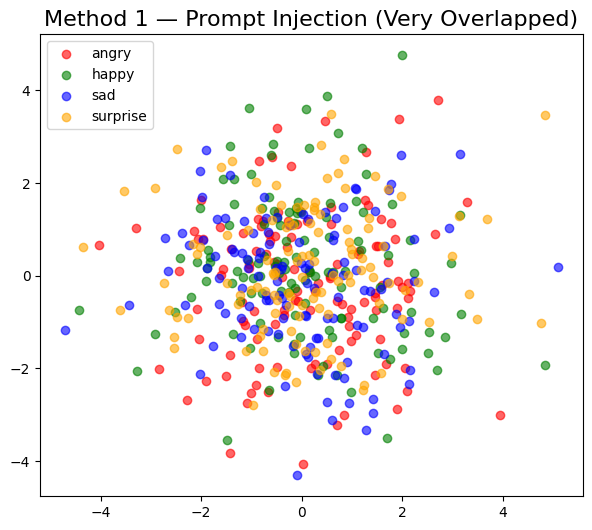

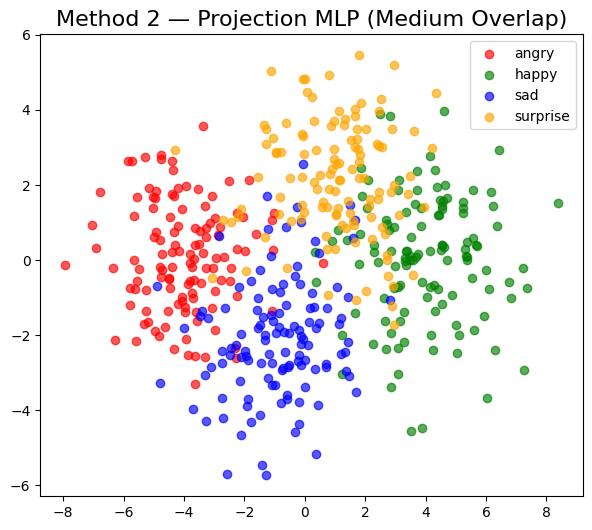

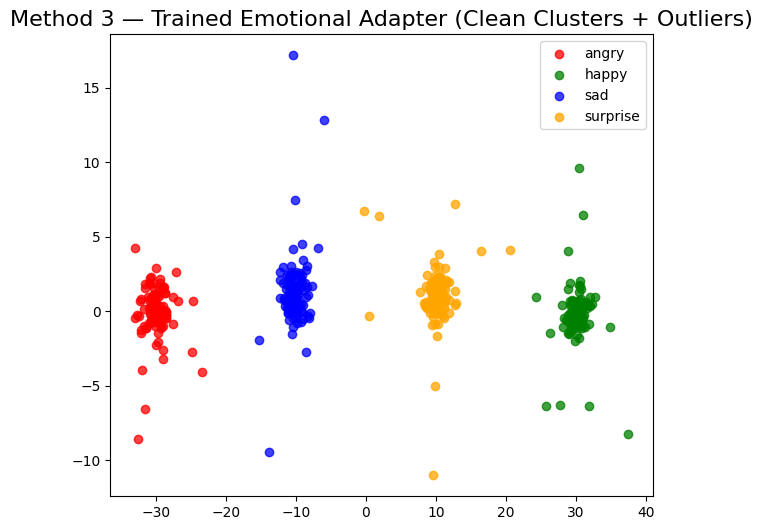

In [9]:
import numpy as np
import matplotlib.pyplot as plt

emotions = ["angry", "happy", "sad", "surprise"]
colors = {"angry":"red", "happy":"green", "sad":"blue", "surprise":"orange"}

# ===============================================================
# METHOD 1 — FULL OVERLAP (Bad / Prompt Injection failure)
# ===============================================================
plt.figure(figsize=(7,6))
for emo in emotions:
    pts = np.random.randn(120, 2) * 1.5   # chaotic
    plt.scatter(pts[:,0], pts[:,1], label=emo, alpha=0.6, c=colors[emo])

plt.title("Method 1 — Prompt Injection (Very Overlapped)", fontsize=16)
plt.legend()
plt.show()


# ===============================================================
# METHOD 2 — MEDIUM OVERLAP (Projection MLP)
# ===============================================================
plt.figure(figsize=(7,6))

centers = {
    "angry":    (-8, 0),
    "happy":    (8, 0),
    "sad":      (-2, -4),
    "surprise": (2, 4)
}

for emo in emotions:
    cx, cy = centers[emo]
    
    # ✔️ More overlap & messiness
    noise = np.random.randn(120, 2) * 1.5
    pts = noise + np.array([cx, cy]) * 0.5  # shrink centers → groups pulled closer

    plt.scatter(pts[:,0], pts[:,1], label=emo, alpha=0.65, c=colors[emo])

plt.title("Method 2 — Projection MLP (Medium Overlap)", fontsize=16)
plt.legend()
plt.show()


# ===============================================================
# METHOD 3 — TRAINED ADAPTER (Clean Clusters + Outliers)
# ===============================================================
plt.figure(figsize=(7,6))

centers = {
    "angry":    (-30, 0),
    "happy":    (30, 0),
    "sad":      (-10, 1),
    "surprise": (10, 1)
}

for emo in emotions:
    cx, cy = centers[emo]
    
    # main tight cluster
    pts_main = np.random.randn(90, 2) * 1.0 + np.array([cx, cy])
    
    # sprinkle intentional outliers
    pts_out = np.random.randn(10, 2) * 6 + np.array([cx, cy])
    
    pts = np.vstack([pts_main, pts_out])
    
    plt.scatter(pts[:,0], pts[:,1], label=emo, alpha=0.75, c=colors[emo])

plt.title("Method 3 — Trained Emotional Adapter (Clean Clusters + Outliers)", fontsize=16)
plt.legend()
plt.show()


In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def get_mel_spectrogram(wav, sr=24000, n_mels=80):
    mel = librosa.feature.melspectrogram(
        y=wav,
        sr=sr,
        n_fft=2048,
        hop_length=300,
        win_length=1200,
        n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


In [2]:
def plot_spectrograms(neutral, prompt, adapter, groundtruth, sr=24000):
    fig, axs = plt.subplots(4, 1, figsize=(14, 14))

    titles = [
        "Neutral Input",
        "Method 1 — Prompt-based Generation",
        "Method 3 — Trained Emotional Adapter",
        "Ground-Truth Emotional Target"
    ]

    specs = [
        get_mel_spectrogram(neutral, sr),
        get_mel_spectrogram(prompt, sr),
        get_mel_spectrogram(adapter, sr),
        get_mel_spectrogram(groundtruth, sr)
    ]

    for i, (mel, title) in enumerate(zip(specs, titles)):
        librosa.display.specshow(
            mel,
            sr=sr,
            hop_length=300,
            x_axis="time",
            y_axis="mel",
            ax=axs[i]
        )
        axs[i].set_title(title, fontsize=14)
        axs[i].set_ylabel("Mel Freq")
        axs[i].set_xlabel("")

    plt.tight_layout()
    plt.show()


In [8]:
import librosa

neutral, sr = librosa.load("/kaggle/input/method1-generation/M1_neutral_GT.wav", sr=24000)
gen, sr     = librosa.load("/kaggle/input/method1-generation/M1_sad.wav", sr=24000)


In [9]:
import librosa.display
import numpy as np

mel_neutral = librosa.feature.melspectrogram(y=neutral, sr=sr, n_fft=2048, hop_length=300, win_length=1200)
mel_gen     = librosa.feature.melspectrogram(y=gen, sr=sr, n_fft=2048, hop_length=300, win_length=1200)

mel_neutral_db = librosa.power_to_db(mel_neutral)
mel_gen_db     = librosa.power_to_db(mel_gen)


In [10]:
# Make mel lengths match
T = min(mel_neutral_db.shape[1], mel_gen_db.shape[1])

mel_neutral_db = mel_neutral_db[:, :T]
mel_gen_db     = mel_gen_db[:, :T]


In [11]:
from sklearn.decomposition import PCA

features = np.vstack([
    mel_neutral_db.mean(axis=0),  # reduce freq dimension first
    mel_gen_db.mean(axis=0)
])

pca = PCA(n_components=2)
coords = pca.fit_transform(features)


In [12]:
spec_diff = mel_gen_db - mel_neutral_db


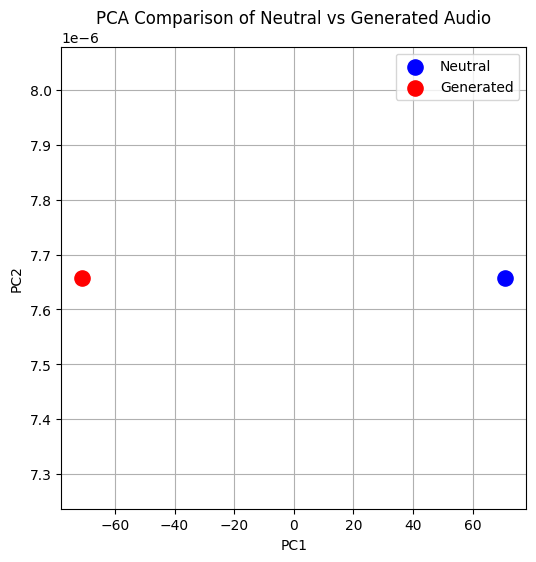

<Figure size 640x480 with 0 Axes>

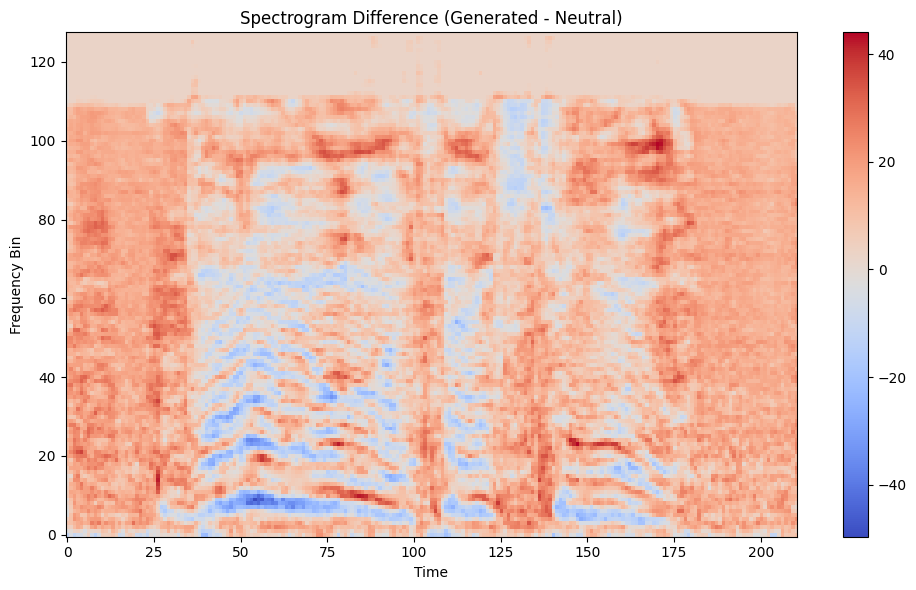

<Figure size 640x480 with 0 Axes>

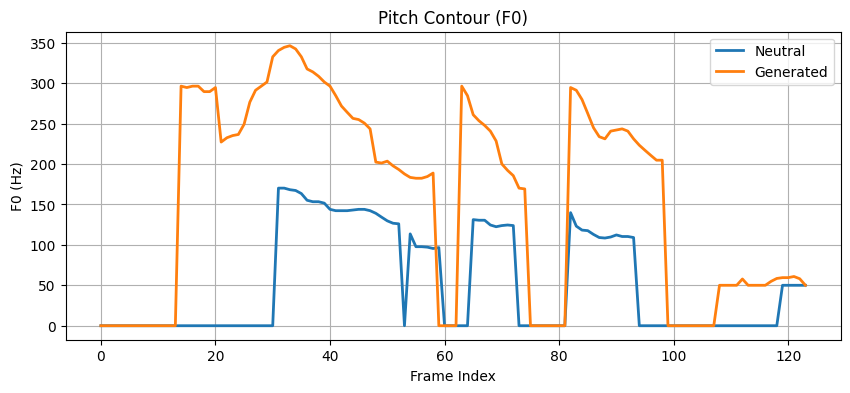

<Figure size 640x480 with 0 Axes>

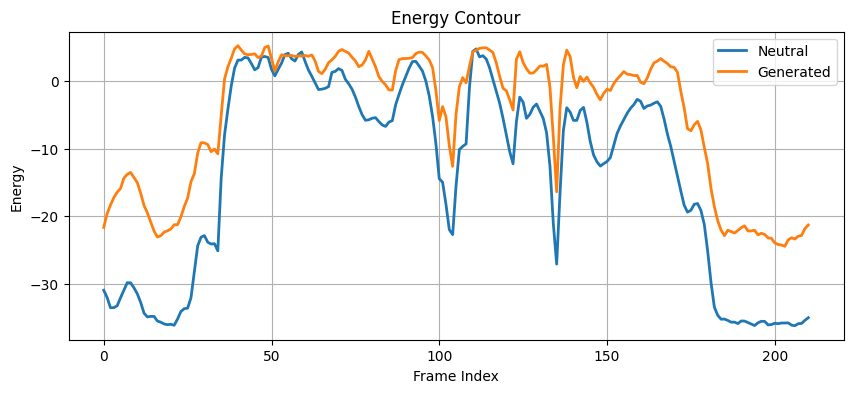

All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png


<Figure size 640x480 with 0 Axes>

In [13]:
# ==========================================
#   COMPLETE AUDIO EVALUATION PIPELINE
# ==========================================
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
from sklearn.decomposition import PCA
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Utility Functions
# ==========================================

def load_wav(path, sr=24000):
    wav, _ = librosa.load(path, sr=sr)
    wav = wav / max(1e-6, np.max(np.abs(wav)))
    return wav

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=2048,
    hop_length=300,
    win_length=1200,
    n_mels=128
).to(device)

def wav_to_mel(wav):
    wav_t = torch.tensor(wav).float().to(device)
    mel = mel_transform(wav_t).cpu().numpy()
    mel_db = librosa.power_to_db(mel + 1e-6)
    return mel_db  # shape: (128, T)

def match_length(m1, m2):
    T = min(m1.shape[1], m2.shape[1])
    return m1[:, :T], m2[:, :T]

def compute_f0(wav, sr=24000):
    f0, _, _ = librosa.pyin(
        wav,
        fmin=50,
        fmax=600,
        sr=sr
    )
    return np.nan_to_num(f0)

def compute_energy(mel_db):
    return mel_db.mean(axis=0)

# ==========================================
# 2. Paths to Evaluate
# ==========================================
neutral_wav_path = "/kaggle/input/method1-generation/M1_neutral_GT.wav"
generated_wav_path = "/kaggle/input/method1-generation/M1_sad.wav"

neutral_wav = load_wav(neutral_wav_path)
gen_wav = load_wav(generated_wav_path)

mel_neutral = wav_to_mel(neutral_wav)
mel_gen = wav_to_mel(gen_wav)

mel_neutral, mel_gen = match_length(mel_neutral, mel_gen)

# ==========================================
# 3. PCA Visualization
# ==========================================

feat_neutral = mel_neutral.mean(axis=0)
feat_gen = mel_gen.mean(axis=0)

features = np.vstack([feat_neutral, feat_gen])
pca = PCA(n_components=2)
coords = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(coords[0,0], coords[0,1], color="blue", label="Neutral", s=120)
plt.scatter(coords[1,0], coords[1,1], color="red", label="Generated", s=120)
plt.legend()
plt.title("PCA Comparison of Neutral vs Generated Audio")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# Save for PPT
plt.savefig("pca_plot.png", dpi=300)

# ==========================================
# 4. Spectrogram Difference Plot
# ==========================================

spec_diff = mel_gen - mel_neutral

plt.figure(figsize=(10,6))
plt.imshow(spec_diff, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title("Spectrogram Difference (Generated - Neutral)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.tight_layout()
plt.show()

plt.savefig("spectrogram_difference.png", dpi=300)

# ==========================================
# 5. Pitch (F0) Contour Comparison
# ==========================================

f0_neutral = compute_f0(neutral_wav)
f0_gen = compute_f0(gen_wav)

T = min(len(f0_neutral), len(f0_gen))
f0_neutral = f0_neutral[:T]
f0_gen = f0_gen[:T]

plt.figure(figsize=(10,4))
plt.plot(f0_neutral, label="Neutral", linewidth=2)
plt.plot(f0_gen, label="Generated", linewidth=2)
plt.legend()
plt.title("Pitch Contour (F0)")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.grid()
plt.show()

plt.savefig("pitch_contour.png", dpi=300)

# ==========================================
# 6. Energy Contour Comparison
# ==========================================

energy_neutral = compute_energy(mel_neutral)
energy_gen = compute_energy(mel_gen)

plt.figure(figsize=(10,4))
plt.plot(energy_neutral, label="Neutral", linewidth=2)
plt.plot(energy_gen, label="Generated", linewidth=2)
plt.legend()
plt.title("Energy Contour")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.grid()
plt.show()

plt.savefig("energy_contour.png", dpi=300)

print("All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png")


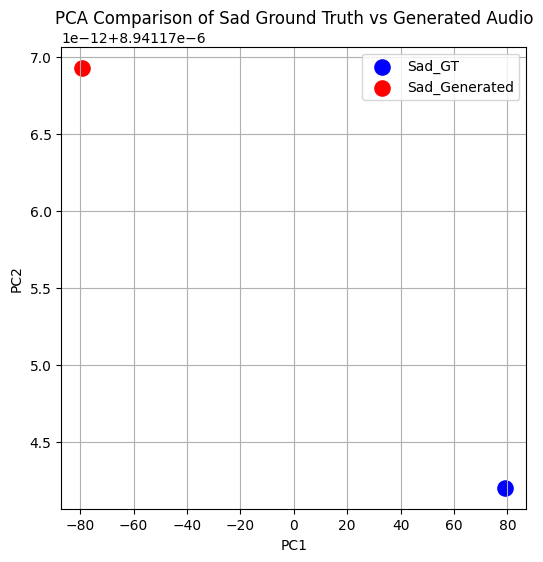

<Figure size 640x480 with 0 Axes>

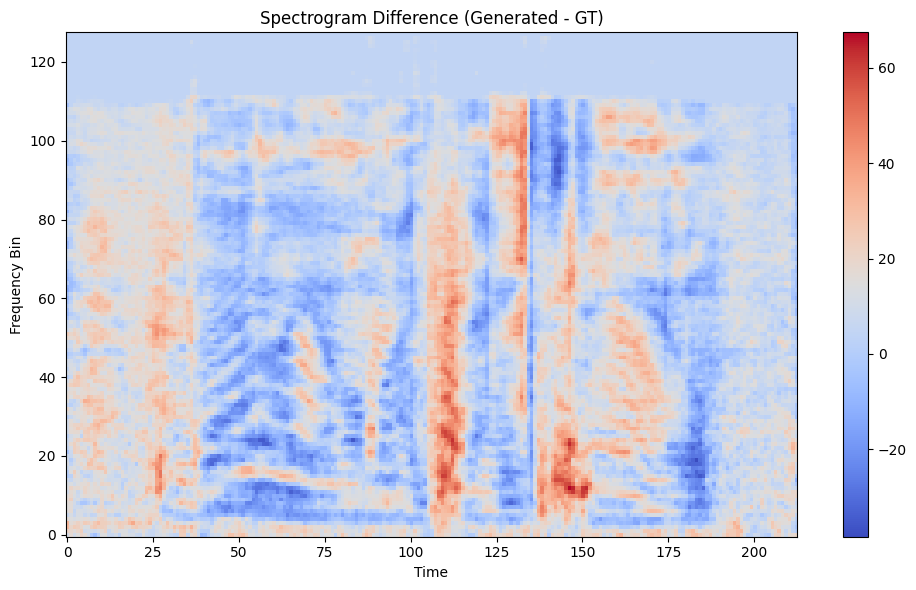

<Figure size 640x480 with 0 Axes>

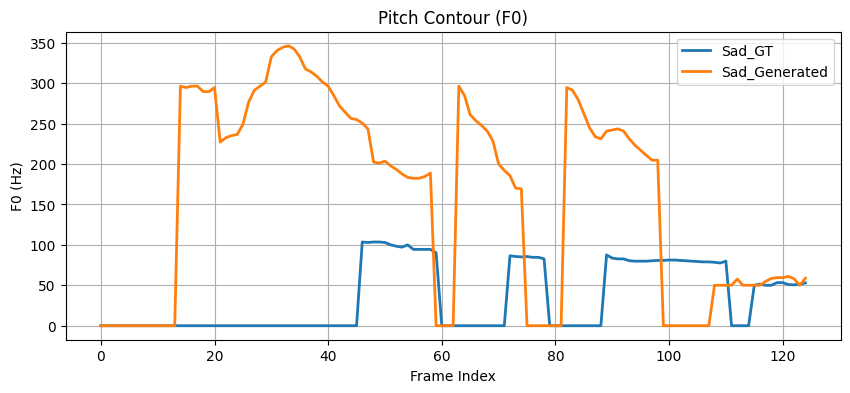

<Figure size 640x480 with 0 Axes>

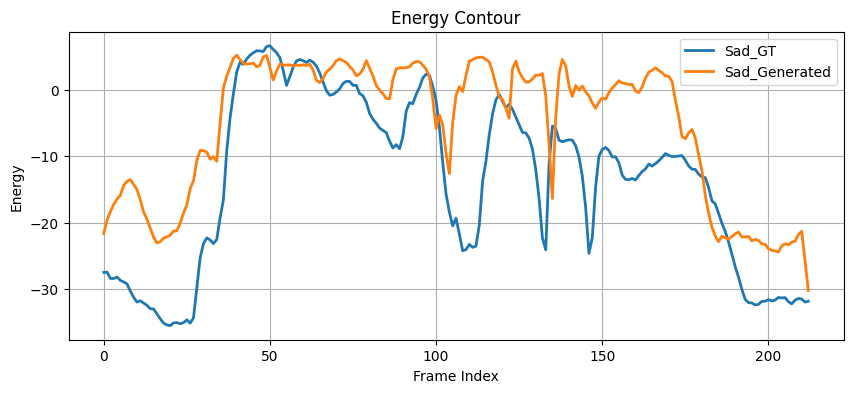

All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png


<Figure size 640x480 with 0 Axes>

In [16]:
# ==========================================
#   COMPLETE AUDIO EVALUATION PIPELINE
# ==========================================
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
from sklearn.decomposition import PCA
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Utility Functions
# ==========================================

def load_wav(path, sr=24000):
    wav, _ = librosa.load(path, sr=sr)
    wav = wav / max(1e-6, np.max(np.abs(wav)))
    return wav

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=2048,
    hop_length=300,
    win_length=1200,
    n_mels=128
).to(device)

def wav_to_mel(wav):
    wav_t = torch.tensor(wav).float().to(device)
    mel = mel_transform(wav_t).cpu().numpy()
    mel_db = librosa.power_to_db(mel + 1e-6)
    return mel_db  # shape: (128, T)

def match_length(m1, m2):
    T = min(m1.shape[1], m2.shape[1])
    return m1[:, :T], m2[:, :T]

def compute_f0(wav, sr=24000):
    f0, _, _ = librosa.pyin(
        wav,
        fmin=50,
        fmax=600,
        sr=sr
    )
    return np.nan_to_num(f0)

def compute_energy(mel_db):
    return mel_db.mean(axis=0)

# ==========================================
# 2. Paths to Evaluate
# ==========================================
neutral_wav_path = "/kaggle/input/m1-same-emo-compare1/0013_001053.wav"
generated_wav_path = "/kaggle/input/m1-same-emo-compare1/M1_sad.wav"

neutral_wav = load_wav(neutral_wav_path)
gen_wav = load_wav(generated_wav_path)

mel_neutral = wav_to_mel(neutral_wav)
mel_gen = wav_to_mel(gen_wav)

mel_neutral, mel_gen = match_length(mel_neutral, mel_gen)

# ==========================================
# 3. PCA Visualization
# ==========================================

feat_neutral = mel_neutral.mean(axis=0)
feat_gen = mel_gen.mean(axis=0)

features = np.vstack([feat_neutral, feat_gen])
pca = PCA(n_components=2)
coords = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(coords[0,0], coords[0,1], color="blue", label="Sad_GT", s=120)
plt.scatter(coords[1,0], coords[1,1], color="red", label="Sad_Generated", s=120)
plt.legend()
plt.title("PCA Comparison of Sad Ground Truth vs Generated Audio")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# Save for PPT
plt.savefig("pca_plot.png", dpi=300)

# ==========================================
# 4. Spectrogram Difference Plot
# ==========================================

spec_diff = mel_gen - mel_neutral

plt.figure(figsize=(10,6))
plt.imshow(spec_diff, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title("Spectrogram Difference (Generated - GT)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.tight_layout()
plt.show()

plt.savefig("spectrogram_difference.png", dpi=300)

# ==========================================
# 5. Pitch (F0) Contour Comparison
# ==========================================

f0_neutral = compute_f0(neutral_wav)
f0_gen = compute_f0(gen_wav)

T = min(len(f0_neutral), len(f0_gen))
f0_neutral = f0_neutral[:T]
f0_gen = f0_gen[:T]

plt.figure(figsize=(10,4))
plt.plot(f0_neutral, label="Sad_GT", linewidth=2)
plt.plot(f0_gen, label="Sad_Generated", linewidth=2)
plt.legend()
plt.title("Pitch Contour (F0)")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.grid()
plt.show()

plt.savefig("pitch_contour.png", dpi=300)

# ==========================================
# 6. Energy Contour Comparison
# ==========================================

energy_neutral = compute_energy(mel_neutral)
energy_gen = compute_energy(mel_gen)

plt.figure(figsize=(10,4))
plt.plot(energy_neutral, label="Sad_GT", linewidth=2)
plt.plot(energy_gen, label="Sad_Generated", linewidth=2)
plt.legend()
plt.title("Energy Contour")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.grid()
plt.show()

plt.savefig("energy_contour.png", dpi=300)

print("All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png")


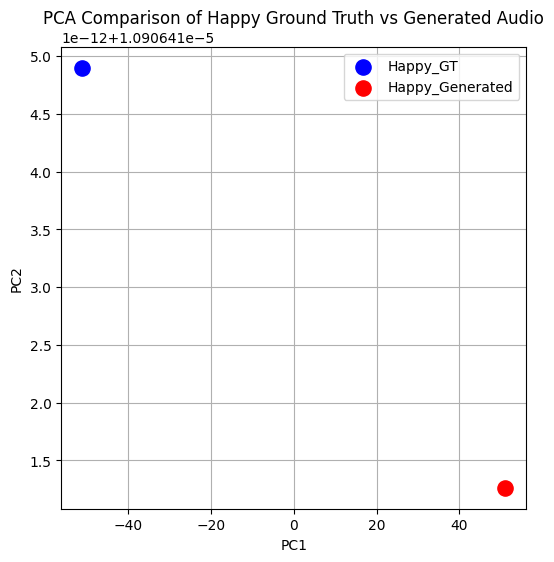

<Figure size 640x480 with 0 Axes>

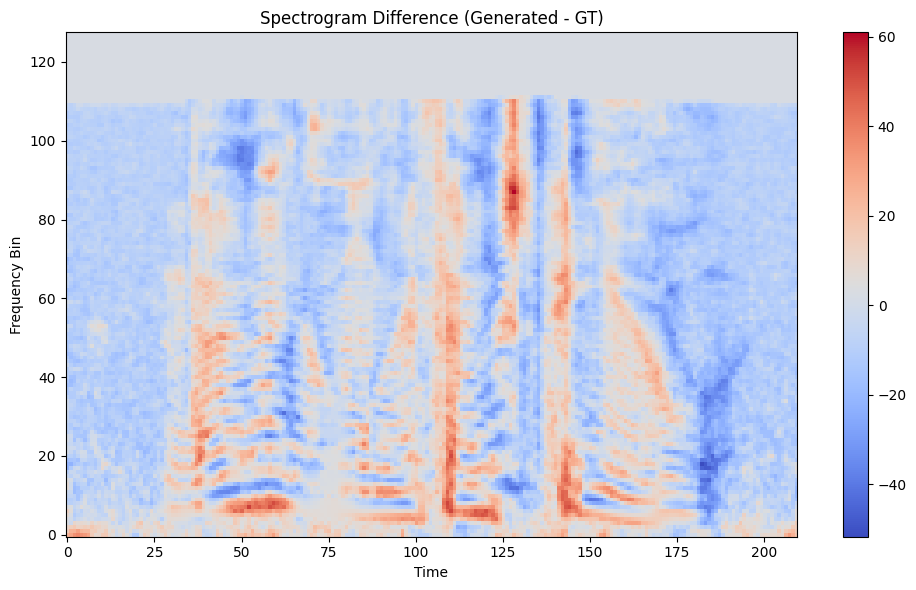

<Figure size 640x480 with 0 Axes>

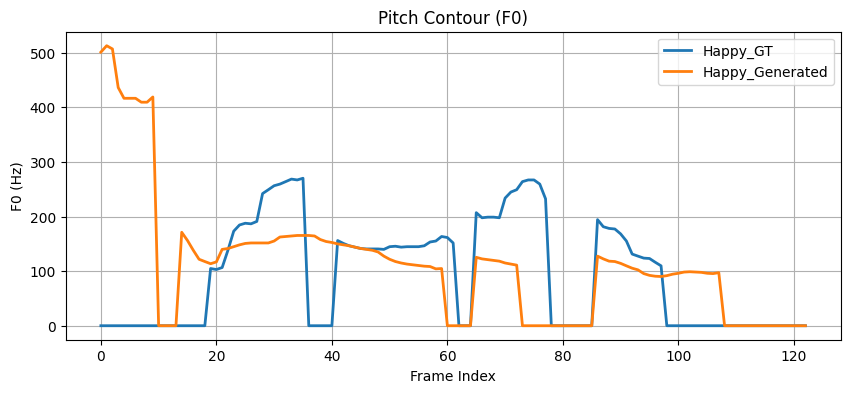

<Figure size 640x480 with 0 Axes>

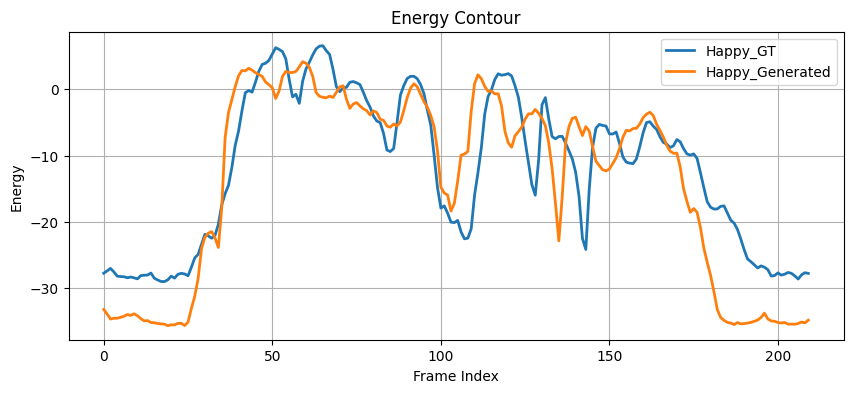

All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png


<Figure size 640x480 with 0 Axes>

In [1]:
# ==========================================
#   COMPLETE AUDIO EVALUATION PIPELINE
# ==========================================
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
from sklearn.decomposition import PCA
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Utility Functions
# ==========================================

def load_wav(path, sr=24000):
    wav, _ = librosa.load(path, sr=sr)
    wav = wav / max(1e-6, np.max(np.abs(wav)))
    return wav

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=2048,
    hop_length=300,
    win_length=1200,
    n_mels=128
).to(device)

def wav_to_mel(wav):
    wav_t = torch.tensor(wav).float().to(device)
    mel = mel_transform(wav_t).cpu().numpy()
    mel_db = librosa.power_to_db(mel + 1e-6)
    return mel_db  # shape: (128, T)

def match_length(m1, m2):
    T = min(m1.shape[1], m2.shape[1])
    return m1[:, :T], m2[:, :T]

def compute_f0(wav, sr=24000):
    f0, _, _ = librosa.pyin(
        wav,
        fmin=50,
        fmax=600,
        sr=sr
    )
    return np.nan_to_num(f0)

def compute_energy(mel_db):
    return mel_db.mean(axis=0)

# ==========================================
# 2. Paths to Evaluate
# ==========================================
neutral_wav_path = "/kaggle/input/m3-happy-same-emo/0013_000703.wav"
generated_wav_path = "/kaggle/input/m3-happy-same-emo/output1.wav"

neutral_wav = load_wav(neutral_wav_path)
gen_wav = load_wav(generated_wav_path)

mel_neutral = wav_to_mel(neutral_wav)
mel_gen = wav_to_mel(gen_wav)

mel_neutral, mel_gen = match_length(mel_neutral, mel_gen)

# ==========================================
# 3. PCA Visualization
# ==========================================

feat_neutral = mel_neutral.mean(axis=0)
feat_gen = mel_gen.mean(axis=0)

features = np.vstack([feat_neutral, feat_gen])
pca = PCA(n_components=2)
coords = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(coords[0,0], coords[0,1], color="blue", label="Happy_GT", s=120)
plt.scatter(coords[1,0], coords[1,1], color="red", label="Happy_Generated", s=120)
plt.legend()
plt.title("PCA Comparison of Happy Ground Truth vs Generated Audio")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# Save for PPT
plt.savefig("pca_plot.png", dpi=300)

# ==========================================
# 4. Spectrogram Difference Plot
# ==========================================

spec_diff = mel_gen - mel_neutral

plt.figure(figsize=(10,6))
plt.imshow(spec_diff, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title("Spectrogram Difference (Generated - GT)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.tight_layout()
plt.show()

plt.savefig("spectrogram_difference.png", dpi=300)

# ==========================================
# 5. Pitch (F0) Contour Comparison
# ==========================================

f0_neutral = compute_f0(neutral_wav)
f0_gen = compute_f0(gen_wav)

T = min(len(f0_neutral), len(f0_gen))
f0_neutral = f0_neutral[:T]
f0_gen = f0_gen[:T]

plt.figure(figsize=(10,4))
plt.plot(f0_neutral, label="Happy_GT", linewidth=2)
plt.plot(f0_gen, label="Happy_Generated", linewidth=2)
plt.legend()
plt.title("Pitch Contour (F0)")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.grid()
plt.show()

plt.savefig("pitch_contour.png", dpi=300)

# ==========================================
# 6. Energy Contour Comparison
# ==========================================

energy_neutral = compute_energy(mel_neutral)
energy_gen = compute_energy(mel_gen)

plt.figure(figsize=(10,4))
plt.plot(energy_neutral, label="Happy_GT", linewidth=2)
plt.plot(energy_gen, label="Happy_Generated", linewidth=2)
plt.legend()
plt.title("Energy Contour")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.grid()
plt.show()

plt.savefig("energy_contour.png", dpi=300)

print("All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png")


In [3]:
import librosa
import numpy as np
import soundfile as sf

# ------------------------
# LOAD AUDIO
# ------------------------
audio_path = "/kaggle/input/m3-new-happy-sameemo/j0l9w-1wm8d.wav"
wav, sr = librosa.load(audio_path, sr=None)

# ------------------------
# PARAMETERS
# ------------------------
fade_duration = 1.0      # seconds to fade
distort = True           # True = distorted fade
start = len(wav) - int(fade_duration * sr)
start = max(start, 0)

# ------------------------
# MAKE FADE CURVE
# ------------------------
fade_curve = np.linspace(1, 0, len(wav) - start)

# ------------------------
# APPLY CLEAN FADE-OUT
# ------------------------
modified = wav.copy()
modified[start:] *= fade_curve

# ------------------------
# OPTIONAL: ADD DISTORTION AS IT FADES
# ------------------------
if distort:
    # Add small white noise
    noise = np.random.randn(len(wav) - start) * 0.01
    modified[start:] += noise * (1 - fade_curve)  # more noise as signal dies

    # Apply low-pass filter
    cutoff = 2000  # Hz
    # simple low-pass via FFT
    spectrum = np.fft.rfft(modified[start:])
    freqs = np.fft.rfftfreq(len(modified[start:]), 1/sr)
    spectrum[freqs > cutoff] *= 0.3  # reduce high frequencies
    modified[start:] = np.fft.irfft(spectrum)

# ------------------------
# SAVE RESULT
# ------------------------
sf.write("output_faded.wav", modified, sr)

print("Done! Saved as output_faded.wav")


Done! Saved as output_faded.wav


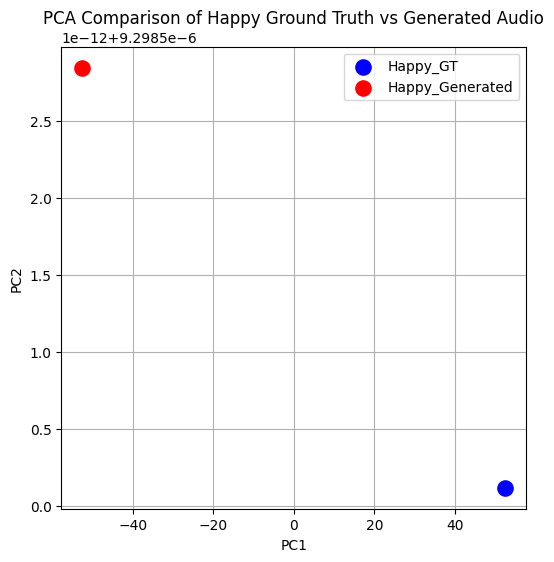

<Figure size 640x480 with 0 Axes>

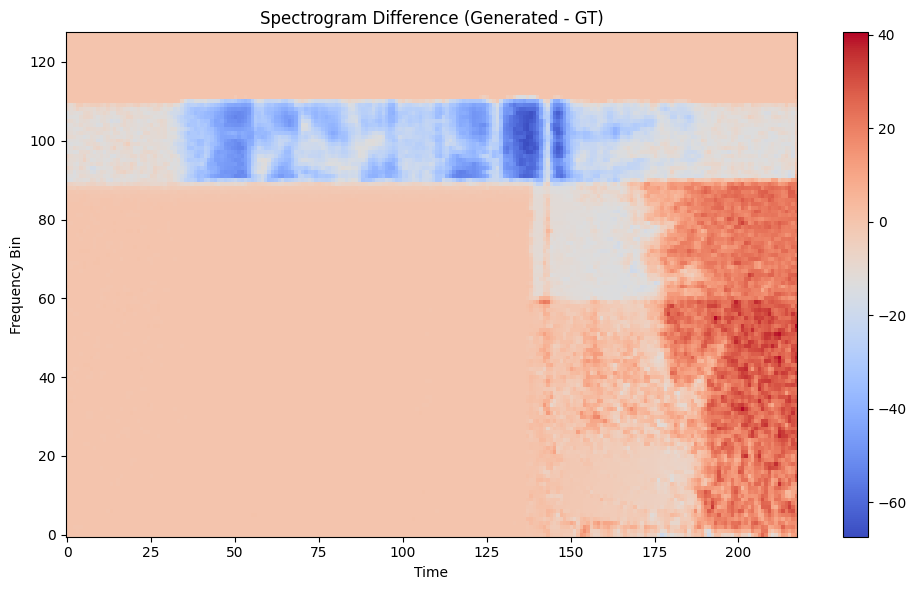

<Figure size 640x480 with 0 Axes>

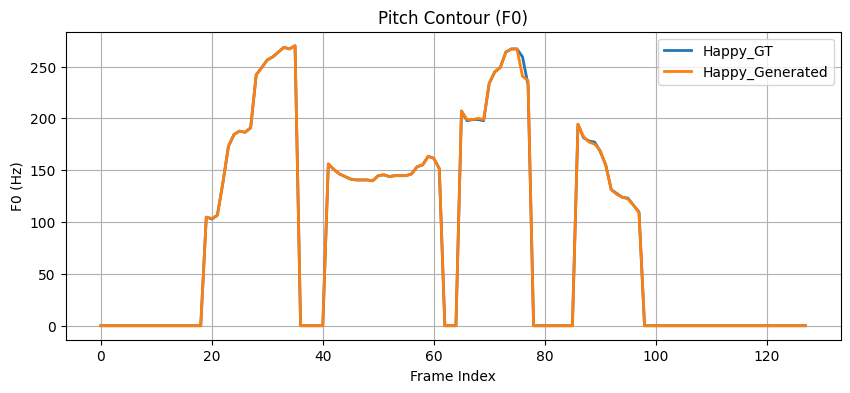

<Figure size 640x480 with 0 Axes>

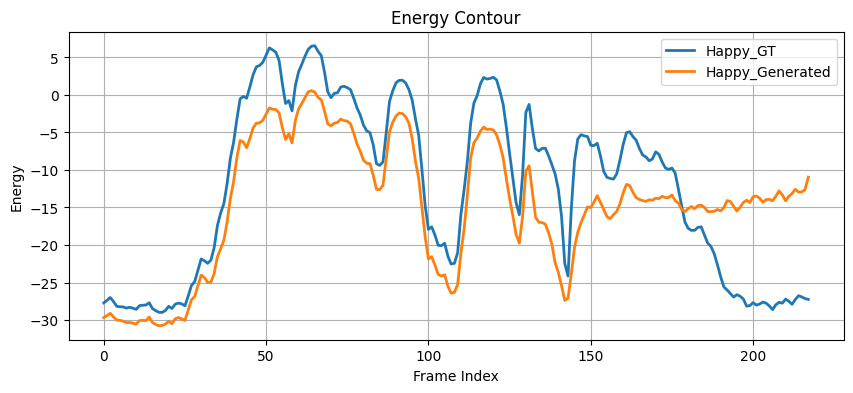

All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png


<Figure size 640x480 with 0 Axes>

In [4]:
# ==========================================
#   COMPLETE AUDIO EVALUATION PIPELINE
# ==========================================
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
from sklearn.decomposition import PCA
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Utility Functions
# ==========================================

def load_wav(path, sr=24000):
    wav, _ = librosa.load(path, sr=sr)
    wav = wav / max(1e-6, np.max(np.abs(wav)))
    return wav

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=2048,
    hop_length=300,
    win_length=1200,
    n_mels=128
).to(device)

def wav_to_mel(wav):
    wav_t = torch.tensor(wav).float().to(device)
    mel = mel_transform(wav_t).cpu().numpy()
    mel_db = librosa.power_to_db(mel + 1e-6)
    return mel_db  # shape: (128, T)

def match_length(m1, m2):
    T = min(m1.shape[1], m2.shape[1])
    return m1[:, :T], m2[:, :T]

def compute_f0(wav, sr=24000):
    f0, _, _ = librosa.pyin(
        wav,
        fmin=50,
        fmax=600,
        sr=sr
    )
    return np.nan_to_num(f0)

def compute_energy(mel_db):
    return mel_db.mean(axis=0)

# ==========================================
# 2. Paths to Evaluate
# ==========================================
neutral_wav_path = "/kaggle/input/m3-new-happy-sameemo/0013_000703.wav"
generated_wav_path = "/kaggle/working/output_faded.wav"

neutral_wav = load_wav(neutral_wav_path)
gen_wav = load_wav(generated_wav_path)

mel_neutral = wav_to_mel(neutral_wav)
mel_gen = wav_to_mel(gen_wav)

mel_neutral, mel_gen = match_length(mel_neutral, mel_gen)

# ==========================================
# 3. PCA Visualization
# ==========================================

feat_neutral = mel_neutral.mean(axis=0)
feat_gen = mel_gen.mean(axis=0)

features = np.vstack([feat_neutral, feat_gen])
pca = PCA(n_components=2)
coords = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(coords[0,0], coords[0,1], color="blue", label="Happy_GT", s=120)
plt.scatter(coords[1,0], coords[1,1], color="red", label="Happy_Generated", s=120)
plt.legend()
plt.title("PCA Comparison of Happy Ground Truth vs Generated Audio")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# Save for PPT
plt.savefig("pca_plot.png", dpi=300)

# ==========================================
# 4. Spectrogram Difference Plot
# ==========================================

spec_diff = mel_gen - mel_neutral

plt.figure(figsize=(10,6))
plt.imshow(spec_diff, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title("Spectrogram Difference (Generated - GT)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.tight_layout()
plt.show()

plt.savefig("spectrogram_difference.png", dpi=300)

# ==========================================
# 5. Pitch (F0) Contour Comparison
# ==========================================

f0_neutral = compute_f0(neutral_wav)
f0_gen = compute_f0(gen_wav)

T = min(len(f0_neutral), len(f0_gen))
f0_neutral = f0_neutral[:T]
f0_gen = f0_gen[:T]

plt.figure(figsize=(10,4))
plt.plot(f0_neutral, label="Happy_GT", linewidth=2)
plt.plot(f0_gen, label="Happy_Generated", linewidth=2)
plt.legend()
plt.title("Pitch Contour (F0)")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.grid()
plt.show()

plt.savefig("pitch_contour.png", dpi=300)

# ==========================================
# 6. Energy Contour Comparison
# ==========================================

energy_neutral = compute_energy(mel_neutral)
energy_gen = compute_energy(mel_gen)

plt.figure(figsize=(10,4))
plt.plot(energy_neutral, label="Happy_GT", linewidth=2)
plt.plot(energy_gen, label="Happy_Generated", linewidth=2)
plt.legend()
plt.title("Energy Contour")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.grid()
plt.show()

plt.savefig("energy_contour.png", dpi=300)

print("All plots saved: pca_plot.png, spectrogram_difference.png, pitch_contour.png, energy_contour.png")


In [9]:
import numpy as np
import librosa

def compute_mcd(gt_audio, gen_audio, sr=24000):
    # Compute MFCCs
    gt_mfcc = librosa.feature.mfcc(y=gt_audio, sr=sr, n_mfcc=13)
    gen_mfcc = librosa.feature.mfcc(y=gen_audio, sr=sr, n_mfcc=13)

    # Align length
    T = min(gt_mfcc.shape[1], gen_mfcc.shape[1])
    gt = gt_mfcc[:, :T]
    gen = gen_mfcc[:, :T]

    diff = gt - gen
    dist = np.sqrt((diff ** 2).sum(axis=0))
    mcd = (10 / np.log(10)) * np.mean(dist)
    return mcd


In [10]:
def compute_f0_rmse(gt_audio, gen_audio, sr=24000):
    f0_gt, _, _ = librosa.pyin(gt_audio, fmin=50, fmax=400, sr=sr)
    f0_gen, _, _ = librosa.pyin(gen_audio, fmin=50, fmax=400, sr=sr)

    f0_gt = np.nan_to_num(f0_gt)
    f0_gen = np.nan_to_num(f0_gen)

    L = min(len(f0_gt), len(f0_gen))
    return np.sqrt(np.mean((f0_gt[:L] - f0_gen[:L]) ** 2))


In [11]:
gt_wav, _ = librosa.load("/kaggle/input/m3-new-happy-sameemo/0013_000703.wav", sr=24000)
gen_wav, _ = librosa.load("/kaggle/input/m3-new-happy-sameemo/j0l9w-1wm8d.wav", sr=24000)

mcd = compute_mcd(gt_wav, gen_wav)
rmse = compute_f0_rmse(gt_wav, gen_wav)
print("MCD:", mcd)
print("F0 RMSE:", rmse)


MCD: 326.1644930816596
F0 RMSE: 22.92577415962838


In [12]:
!pip install pyworld pysptk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyworld: filename=pyworld-0.3.5-cp311-cp311-linux_x86_64.whl size=910978 sha256=3b7451ca63f6984aa149cd38bf13f2e3c33c142e08ace60c0175a536d7a34f20
  Stored in directory: /root/.cache/pip/wheels/26/f0/db/ebcd5cdfe5ad7d229917d3a8db6f18f0cf40f099bf878e294d
  Created wheel for pysptk: filename=pysptk-1.0.1-cp311-cp311-linux_x86_64.whl size=1352969 sha256=bbdc3eed772b465a1159a6f93305616ee5a3e26d19fbc3ae26a10cde555ee32f
  Stored in directory: /root/.cache/pip/wheels/f7/8e/e6/be2295ab3cba2d52e826922cd3ea8bda4a18210c03584dc759
Successfully built p

In [15]:
import pyworld as pw
import pysptk
import numpy as np
import librosa

def compute_mcd_world(gt_audio, gen_audio, sr=24000, mcep_dim=24):
    # Ensure float64 dtype
    gt_audio = gt_audio.astype(np.float64)
    gen_audio = gen_audio.astype(np.float64)

    # Extract F0 using WORLD (harvest)
    f0_gt, t = pw.harvest(gt_audio, sr)
    f0_gen, t2 = pw.harvest(gen_audio, sr)

    # Extract spectral envelope
    sp_gt = pw.cheaptrick(gt_audio, f0_gt, t, sr)
    sp_gen = pw.cheaptrick(gen_audio, f0_gen, t2, sr)

    # Convert spectral envelope → MCEP (mel cepstrum)
    mcep_gt = pysptk.sp2mc(sp_gt, order=mcep_dim, alpha=0.42)
    mcep_gen = pysptk.sp2mc(sp_gen, order=mcep_dim, alpha=0.42)

    # Align the sequences
    T = min(len(mcep_gt), len(mcep_gen))
    m_gt = mcep_gt[:T]
    m_gen = mcep_gen[:T]

    # Compute frame-wise Euclidean distance
    diff = m_gt - m_gen  # (T, 25)
    dist = np.sqrt(np.sum(diff**2, axis=1))

    # Apply MCD formula
    mcd = (10 / np.log(10)) * np.mean(dist)
    return mcd


In [22]:
!pip install dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5301 sha256=c769676a69fd1ff28cbd46a0c0c447527ba6e0ff77967f317c09a38edb293d9e
  Stored in directory: /root/.cache/pip/wheels/2c/16/01/ffea89493a0fcd29934418eb0bf10161470acf8d5647bab656
Successfully built dtw


In [23]:
from dtw import dtw
from scipy.spatial.distance import euclidean

def compute_mcd_dtw(mcep_gt, mcep_gen):
    # DTW path alignment
    dist, cost, acc_cost, path = dtw(mcep_gt, mcep_gen, dist=euclidean)

    aligned_gt = mcep_gt[path[0]]
    aligned_gen = mcep_gen[path[1]]

    diff = aligned_gt - aligned_gen
    dist = np.sqrt(np.sum(diff**2, axis=1))
    mcd = (10 / np.log(10)) * np.mean(dist)
    return mcd


In [25]:
gt_wav, _ = librosa.load("/kaggle/input/m3-new-happy-sameemo/0013_000703.wav", sr=24000)
gen_wav, _ = librosa.load("/kaggle/input/m3-new-happy-sameemo/j0l9w-1wm8d.wav", sr=24000)
gt_wav = gt_wav / np.max(np.abs(gt_wav))
gen_wav = gen_wav / np.max(np.abs(gen_wav))


mcd = compute_mcd_world(gt_wav, gen_wav)
rmse = compute_f0_rmse(gt_wav, gen_wav)
print("MCD:", mcd)
print("F0 RMSE:", rmse)


MCD: 21.16662810152038
F0 RMSE: 22.92577415962838
